In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns

In [3]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [191]:
from sklearn.feature_selection import f_classif,SelectKBest, chi2, RFE
from scipy.stats import kendalltau
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance

In [5]:
random_state = 505

In [6]:
df = pd.read_csv('../data/dataset_with_features_200_20.csv')
df.head()

,Covert,Mean,Std,Median,Skew,Kurtosis,NumberUniqueValues,ModeFreq,NumberModesKDE,NumberModesPareto,...,1stLocOfMinimum,RatioBeyond2.5,ValueCounts_4,ValueCounts_6,ValueCounts_9,ValueCounts_43,ValueCounts_44,RMSE,MAE,SymmetricTest
0,1,20.394,9.764,19.103,0.375,-0.770,39,0.050,1,0,...,0.26,0.0,1,1,8,2,0,9.740,8.163,38.125
1,1,20.640,9.600,19.684,0.418,-0.664,39,0.050,1,0,...,0.16,0.0,1,2,9,3,0,9.576,7.979,38.572
2,1,21.181,9.920,20.655,0.354,-0.816,39,0.045,2,1,...,0.06,0.0,1,3,7,3,0,9.895,8.325,39.002
3,1,21.118,9.790,20.779,0.361,-0.788,38,0.045,2,2,...,0.93,0.0,0,3,7,3,0,9.765,8.182,38.484
4,1,20.979,9.873,20.560,0.381,-0.825,38,0.050,2,1,...,0.83,0.0,0,4,6,2,0,9.848,8.249,38.403


# Описание признаков

1. Mean
2. Std
3. Median


77. SymmetricTest

# Подготовка данных

In [7]:
covert = df[df['Covert'] == 1]

In [8]:
overt = df[df['Covert'] == 0].reset_index(drop=True)

In [9]:
hold_size = 500
train_size_covert = 500
train_size_overt = 500

Оставим hold часть для финальной оценки качества моделей

In [10]:
df_hold = pd.concat((covert[-hold_size:], overt[-hold_size:]), ignore_index=True, sort=False)

In [11]:
X_hold = df_hold.drop(['Covert'], axis=1)
y_hold = df_hold['Covert']

In [12]:
np.random.seed(random_state)
covert_indexes = np.random.randint(0, df.shape[0] // 2 - hold_size * 2, train_size_covert)

In [13]:
np.random.seed(random_state // 2)
overt_indexes = np.random.randint(0, df.shape[0] // 2 - hold_size * 2, train_size_overt)

In [14]:
df_train = pd.concat((covert.loc[covert_indexes], overt.loc[overt_indexes]), ignore_index=True, sort=False)

In [261]:
def calculate_cross_val_score(estimator, X, y):
    """ Функция вычисляет среднее значение F1-меры при кросс-валидации с 5 фолдами """
    return np.mean(cross_val_score(estimator, X, y, scoring='f1',
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)))

** Почему в качестве метрики качества классификации выбрана F1-мера? **

Потому что она учитывает как полноту, так и точность обнаружения скрытого канала.

In [ ]:
results_features = pd.DataFrame(df.columns[1:], columns=['feature_name'])
results_features['Baseline (76)'] = 1

In [19]:
results_models = pd.DataFrame(columns=['DecisionTree', 'SVM', 'RF', 'Mean'])

# Бейзлайн
Первая версия - используются все признаки. Качество предсказания проверяется с помощью функции `calculate_cross_val_score` для трёх моделей. Обоснование их выбора:
- `DecisionTreeClassifier` - классическое решающее дерево для классификации. Модель выбрана из-за скорости работы и интерпретируемости.
- `SVM` - метод опорных векторов. Среди линейных моделей выбран именно он, так как показал лучшие результаты на кросс-валидации и встречается в большинстве работ по обнаружению скрытых каналов у других авторов.
- `RandomForestClassifier` - случайный лес. Выбран в качестве более "сложной" модели, так как показал высокие результаты на кросс-валидации. Так же была попытка использовать разные вариации градиентного бустинга, однако из-за небольшого размера выборки модели сильно переобучались, и был сделан выбор в пользу более простых вариантов.

Все модели используются с параметрами по умолчанию и фиксированным `random_state`.

### Decision Tree

In [20]:
X = df_train.drop(['Covert'], axis=1)
y = df_train['Covert']

In [23]:
tree = DecisionTreeClassifier(random_state=random_state)
dt_baseline = calculate_cross_val_score(tree, X, y)
print(dt_baseline)

0.9077625709134292


#### Визуализация дерева

In [58]:
fitted_tree = DecisionTreeClassifier(random_state=random_state).fit(X, y)

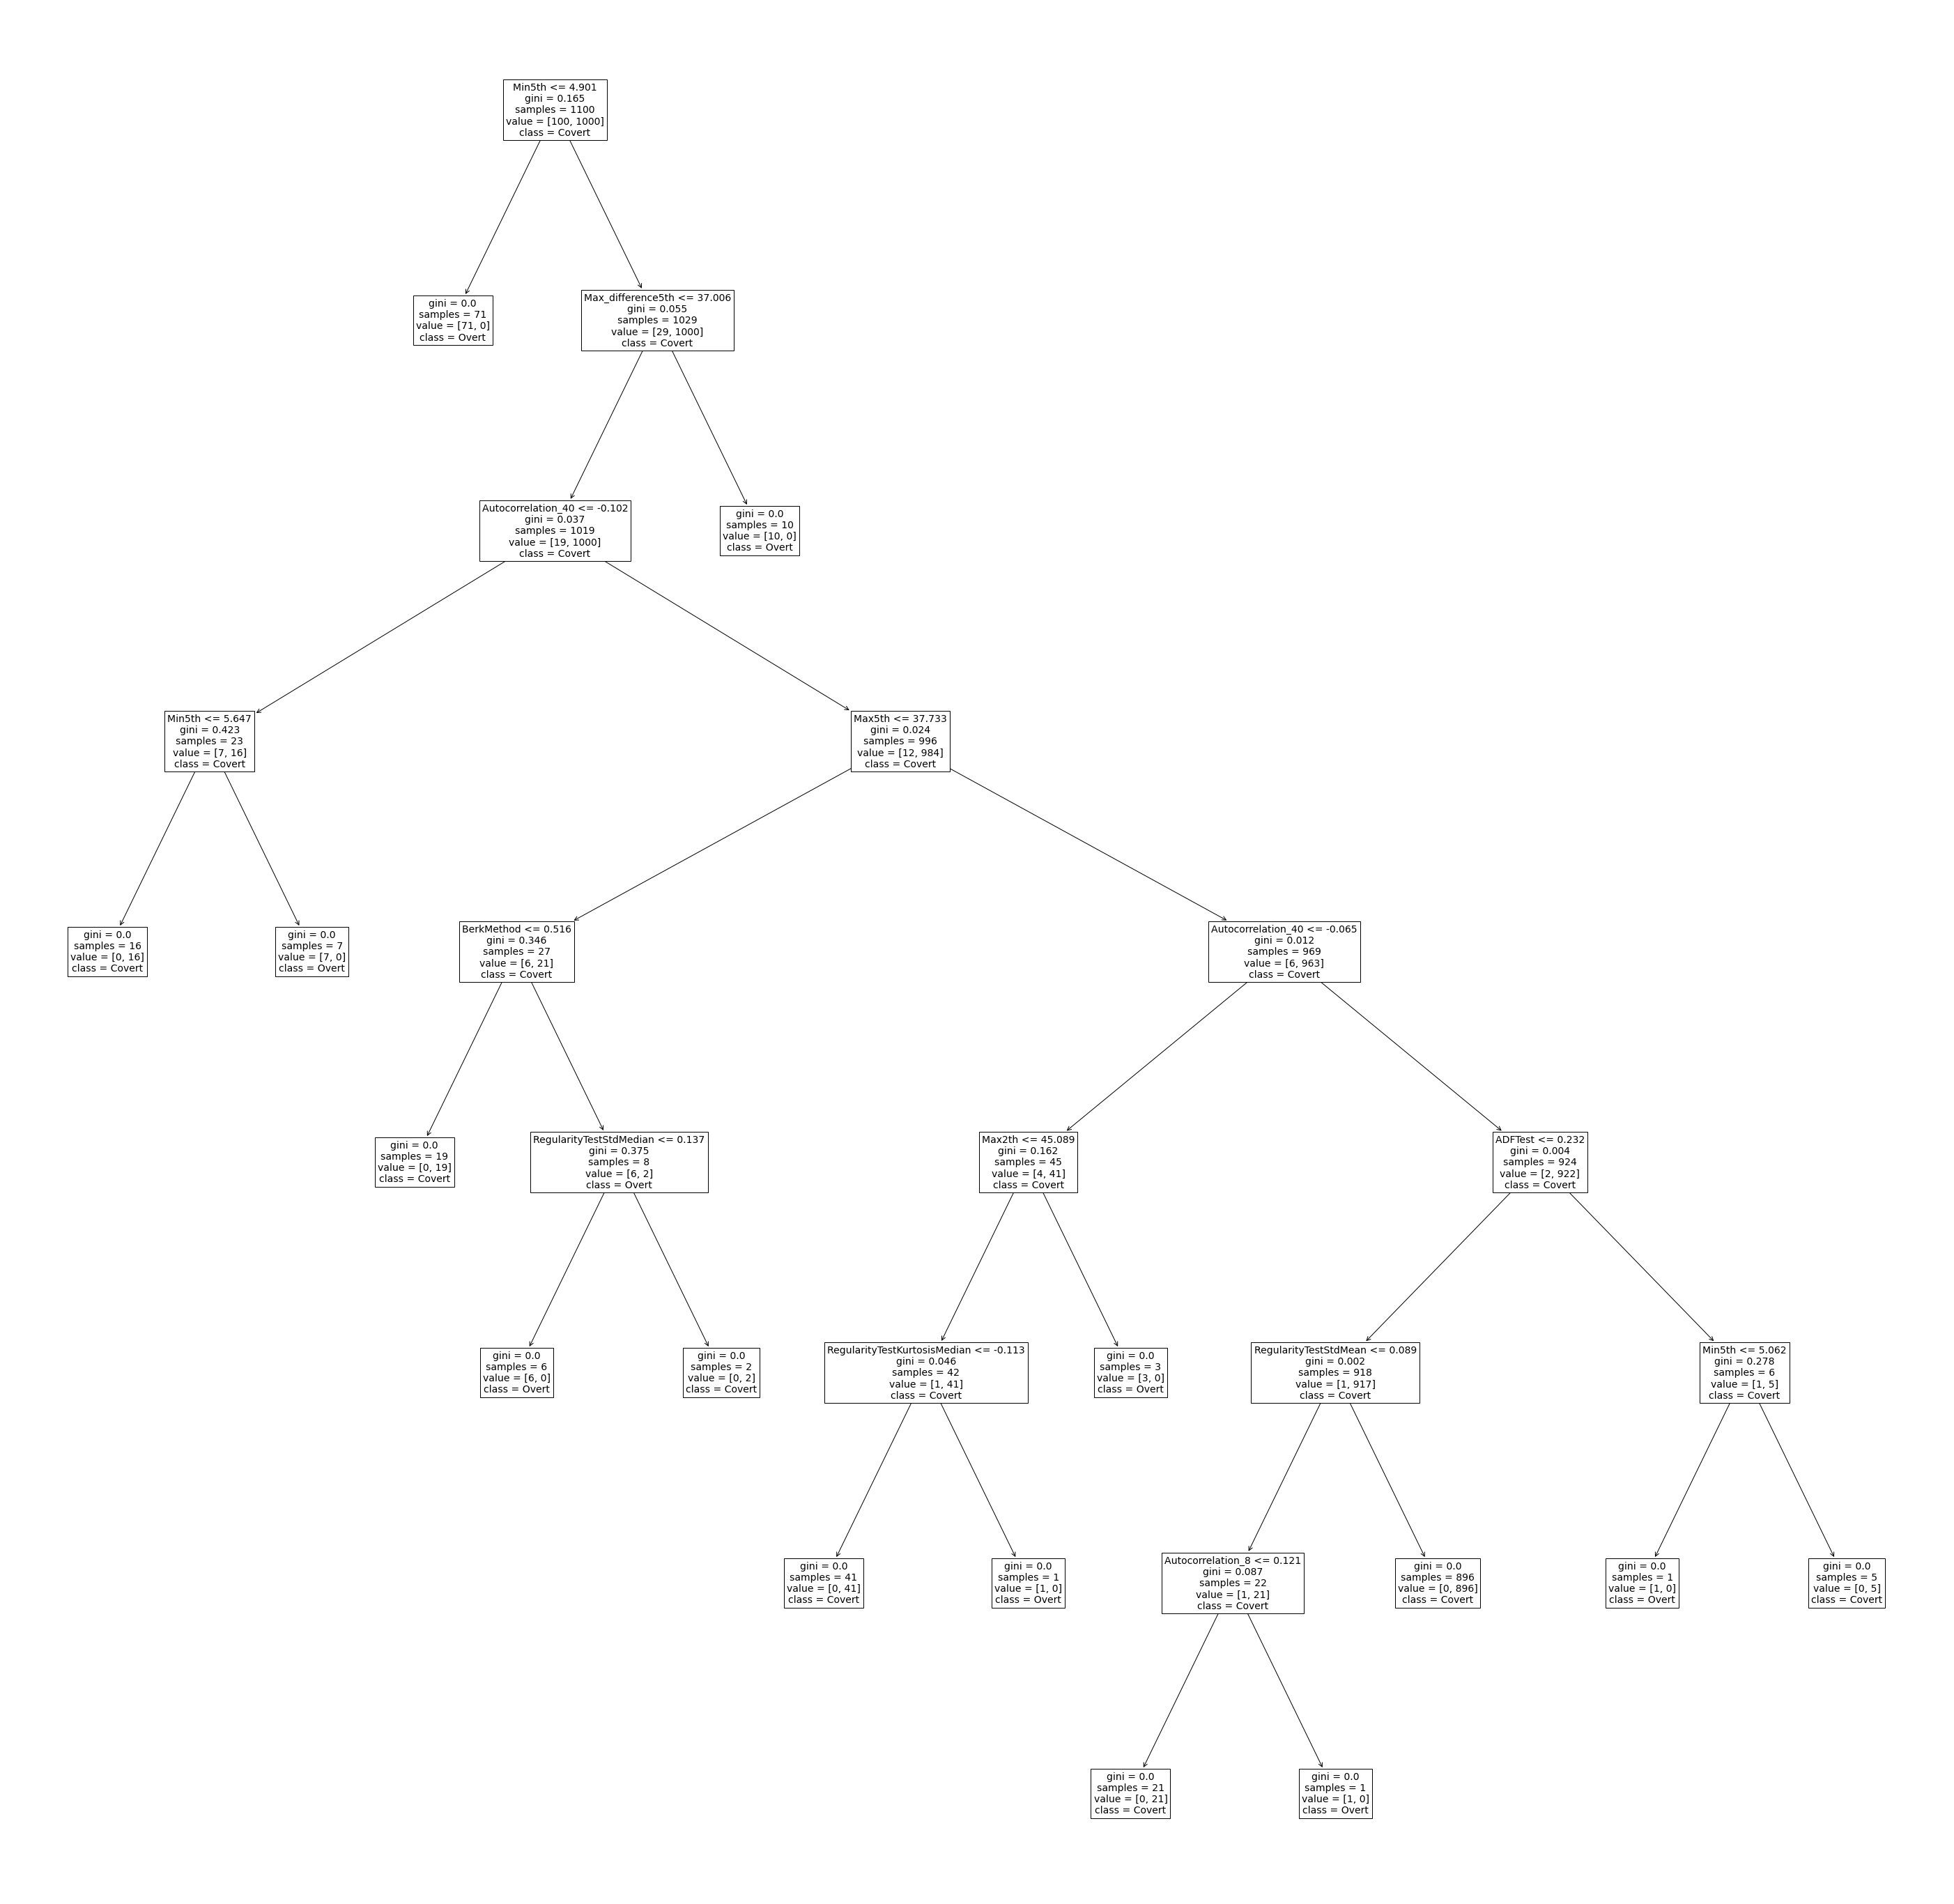

In [112]:
plt.subplots(figsize=(50, 50))
plot_tree(fitted_tree, feature_names=X.columns, class_names=['Overt', 'Covert'], fontsize=14)
plt.savefig('../data/features_selection/tree.png')

### SVM

In [24]:
standard_scaler = StandardScaler().fit(X)

In [25]:
X_std_scaled = pd.DataFrame(standard_scaler.transform(X), columns=X.columns)

In [26]:
svc = SVC(random_state=random_state)
svm_baseline = calculate_cross_val_score(svc, X_std_scaled, y)
print(svm_baseline)

0.8738359919650243


### RF

In [27]:
rf = RandomForestClassifier(random_state=random_state)
rf_baseline = calculate_cross_val_score(rf, X, y)
print(rf_baseline)

0.9443119999924978


### Функция для тестирования метода отбора признаков

In [67]:
def evaluate_feature_selection_method(features_to_use, method_name):
    """ 
    Функция, тестирующая качество работы метода отбора признаков
    
    :param features_to_use: list, отобранные методом признаки
    :param method_name: str, название метода отбора, которое будет записано в results_models
    """
    
    cross_val_scores = []
    
    print('Method:', method_name)
    tree = DecisionTreeClassifier(random_state=random_state)
    dt_score = round(calculate_cross_val_score(tree, X[features_to_use], y), 3)
    cross_val_scores.append(dt_score)
    print('Decision Tree:', dt_score)
    
    svm = SVC(random_state=random_state)
    svm_score = round(calculate_cross_val_score(svm, X_std_scaled[features_to_use], y), 3)
    cross_val_scores.append(svm_score)
    print('SVM:', svm_score)
    
    rf = RandomForestClassifier(random_state=random_state)
    rf_score = round(calculate_cross_val_score(rf, X[features_to_use], y), 3)
    cross_val_scores.append(rf_score)
    print('RF:', rf_score)
    
    mean = round(np.mean(cross_val_scores), 3)
    print('Mean:', mean)
    print('Save results into results_models dataframe')
    results_models.loc[method_name] = cross_val_scores + [mean]

Сохранение бейзлайн-результатов

In [70]:
scores_baseline = [dt_baseline, svm_baseline, rf_baseline]
results_models.loc['Baseline (76)'] = np.round(scores_baseline + [np.mean(scores_baseline)], 3)

# Отбор признаков

## Unsupervised methods
Анализ корреляции между признаками

In [30]:
corr = X.corr()

<AxesSubplot:>

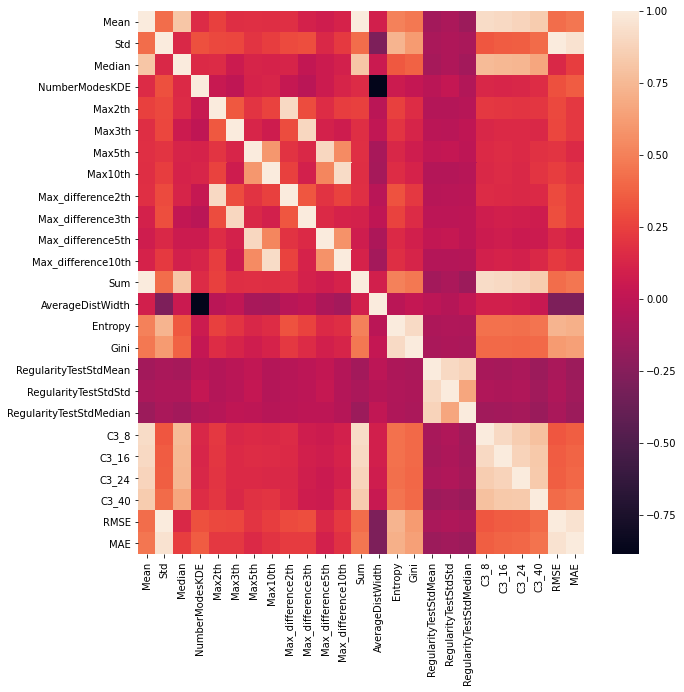

In [88]:
plt.subplots(figsize=(10, 10))

sns.heatmap(corr.loc[np.sum(np.abs(corr) > 0.8) > 1, np.sum(np.abs(corr) > 0.8) > 1])

Вывод признаков, чья линейная корреляция по модулю > 0.85

In [103]:
threshold = 0.85
features = corr.columns

for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        corr_coeff = corr.iloc[i, j]
        if abs(corr_coeff) > threshold:
            print(f'{features[i]} and {features[j]} - {np.round(corr_coeff, 3)}')

Mean and Sum - 1.0
Mean and C3_8 - 0.919
Mean and C3_16 - 0.905
Mean and C3_24 - 0.887
Std and RMSE - 1.0
Std and MAE - 0.951
NumberModesKDE and AverageDistWidth - -0.888
Max2th and Max_difference2th - 0.906
Max3th and Max_difference3th - 0.9
Max5th and Max_difference5th - 0.899
Max10th and Max_difference10th - 0.921
Sum and C3_8 - 0.919
Sum and C3_16 - 0.905
Sum and C3_24 - 0.887
Entropy and Gini - 0.912
RegularityTestStdMean and RegularityTestStdStd - 0.909
RegularityTestStdMean and RegularityTestStdMedian - 0.881
C3_8 and C3_16 - 0.909
C3_16 and C3_24 - 0.875
RMSE and MAE - 0.951


Из каждой пары сильнокоррелирующих признаков удаляется один представитель

In [31]:
corr_method_to_delete = {
    'Sum',
    'RMSE',
    'MAE',
    'Max_difference2th',
    'Max_difference3th',
    'Max_difference10th',
    'C3_8',
    'C3_16',
    'C3_24',
    'AverageDistWidth',
    'Gini',
    'RegularityTestStdMean'
}

In [32]:
results_features['Correlation (64)'] = results_features['feature_name'].apply(lambda feat: (feat not in corr_method_to_delete) * 1)

In [68]:
evaluate_feature_selection_method(list(set(X.columns) - corr_method_to_delete), 'Correlation (64)')

Method: Correlation (64)
Decision Tree: 0.913
SVM: 0.878
RF: 0.942
Mean: 0.911
Save results into results_models dataframe


## Filter methods
Методы, использующие статистические критерии, в которых участвуют признаки и таргет 

In [34]:
features_to_use = list(set(X.columns) - set(corr_method_to_delete))

### 1. ANOVA F-test

In [35]:
anova = f_classif(X_std_scaled[features_to_use], y)

In [36]:
anova_to_use = set([feat_name for _, feat_name in sorted(zip(anova[0], features_to_use), 
                                                         key=lambda x: x[0], reverse=True)[:35]])

In [37]:
results_features['Anova (35)'] = results_features['feature_name'].apply(lambda feat: (feat in anova_to_use) * 1)

In [72]:
evaluate_feature_selection_method(anova_to_use, 'Anova (35)')

Method: Anova (35)
Decision Tree: 0.911
SVM: 0.891
RF: 0.943
Mean: 0.915
Save results into results_models dataframe


### 2. Kendall Tau test

In [44]:
kendall_corrs = []

for feature in features_to_use:
    kendall_corrs.append(kendalltau(X[feature], y).correlation)

In [45]:
kendall_to_use = \
    set([feat_name for _, feat_name in sorted(zip(np.abs(kendall_corrs), features_to_use), 
                                              key=lambda x: x[0], reverse=True)[:20]])

In [46]:
results_features['Kendall (20)'] = \
    results_features['feature_name'].apply(lambda feat: (feat in kendall_to_use) * 1)

In [73]:
evaluate_feature_selection_method(kendall_to_use, 'Kendall (20)')

Method: Kendall (20)
Decision Tree: 0.904
SVM: 0.882
RF: 0.931
Mean: 0.906
Save results into results_models dataframe


### 3. Chi2

In [48]:
minmax = MinMaxScaler().fit(X)
X_minmax = pd.DataFrame(minmax.transform(X), columns=X.columns)

In [49]:
chi = chi2(X_minmax[features_to_use], y)

In [50]:
chi_to_use = set([feat_name for _, feat_name in sorted(zip(chi[0], features_to_use), 
                                                         key=lambda x: x[0], reverse=True)[:40]])

In [153]:
results_features[f'Chi2 ({len(chi_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in chi_to_use) * 1)

In [74]:
evaluate_feature_selection_method(chi_to_use, f'Chi2 ({len(chi_to_use)})')

Method: Chi2 (40)
Decision Tree: 0.91
SVM: 0.888
RF: 0.943
Mean: 0.914
Save results into results_models dataframe


## Feature importances
Группа методов, использующих при отборе вес, который признаки приобретают в процессе обучения конкретной модели

### 1. Linear coefficients
У линейных моделей значимость признака определяется весом коэффициента, соответсвующего данному признаку. В качестве линейной модели классификации используется логистическая регрессия с L1-регуляризацией, которая зануляет веса незначимых признаков.

In [52]:
lr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')

In [53]:
lr.fit(X_std_scaled[features_to_use], y)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [54]:
weights = lr.coef_

In [55]:
linear_to_use = np.array(features_to_use)[weights[0] != 0]

In [56]:
results_features[f'Linear weights ({len(linear_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in linear_to_use) * 1)

In [75]:
evaluate_feature_selection_method(linear_to_use, f'Linear weights ({len(linear_to_use)})')

Method: Linear weights (34)
Decision Tree: 0.863
SVM: 0.88
RF: 0.923
Mean: 0.889
Save results into results_models dataframe


### 2. Decision Tree FE
У решающих деревьев feature importance определяется как суммарное величина на которую этот признак уменьшил значение критерия Джини при расщеплении. 

27


Text(0.5, 1.0, 'Decision Tree (baseline) Feature Importance')

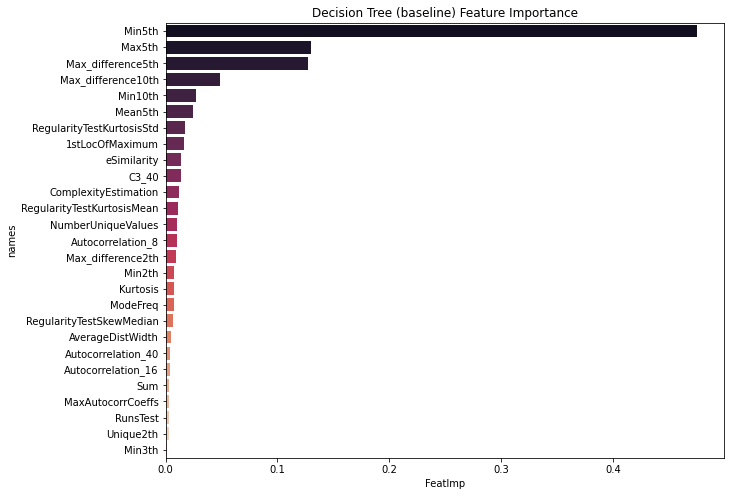

In [59]:
fig, ax = plt.subplots(figsize=(10, 8))

feat_imp = pd.DataFrame({
    'names': X.columns,
    'FeatImp': fitted_tree.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0]
print(feat_imp.shape[0])
dt_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('Decision Tree (baseline) Feature Importance')

Поиск оптимальных гиперпараметров для `DecisionTreeClassifier`

In [60]:
tree_parameters = {
    'criterion': ['gini', 'entropy'],
#     'splitter' : ['best', 'random'], 
    'max_depth': [4, 5, 6, 7, 8, 10],
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [2, 3]
}

In [61]:
rgs = RandomizedSearchCV(DecisionTreeClassifier(random_state=random_state),
                        tree_parameters, 
                        n_iter=200,
                        scoring='f1',
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))

In [62]:
rgs.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=505, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=505),
                   n_iter=200,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8, 10],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3]},
                   scoring='f1')

In [63]:
rgs.best_score_, rgs.best_params_

(0.9219318028275643,
 {'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_depth': 5,
  'criterion': 'gini'})

8


Text(0.5, 1.0, 'Decision Tree (tuned) Feature Importance')

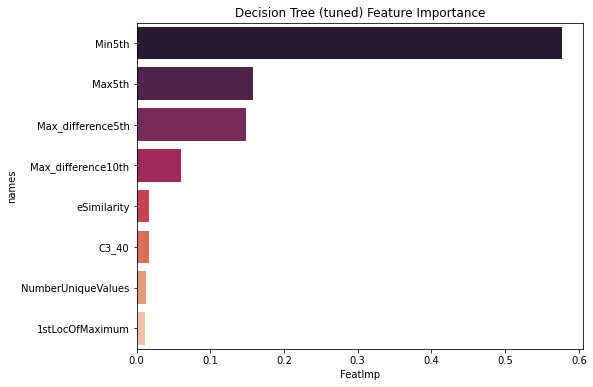

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

feat_imp = pd.DataFrame({
    'names': X.columns,
    'FeatImp': rgs.best_estimator_.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0]
print(feat_imp.shape[0])
rgs_dt_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('Decision Tree (tuned) Feature Importance')

In [99]:
results_features[f'DT FE ({len(rgs_dt_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in set(rgs_dt_to_use)) * 1)

In [76]:
evaluate_feature_selection_method(rgs_dt_to_use, f'DT FE ({len(rgs_dt_to_use)})')

Method: DT FE (8)
Decision Tree: 0.893
SVM: 0.875
RF: 0.936
Mean: 0.901
Save results into results_models dataframe


### 3. Random Forest FE 
У случайного леса feature importance вычисляется аналогично решающему дереву, только величина для каждого признака суммируется по всем деревьям в лесе.

In [82]:
rf.fit(X[features_to_use], y)

RandomForestClassifier(random_state=505)

13


Text(0.5, 1.0, 'RF (baseline) Feature Importance')

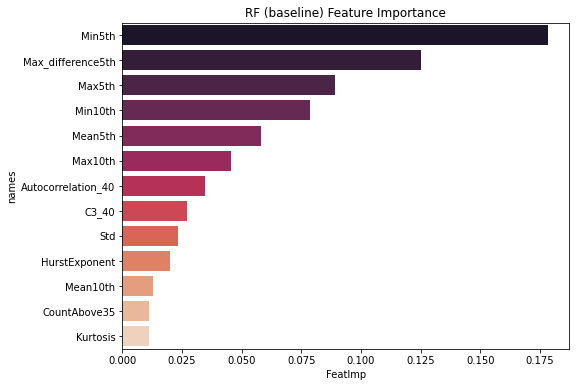

In [85]:
fig, ax = plt.subplots(figsize=(8, 6))

feat_imp = pd.DataFrame({
    'names': features_to_use,
    'FeatImp': rf.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0.01]
print(feat_imp.shape[0])
rf_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('RF (baseline) Feature Importance')

In [95]:
set(rf_to_use)

{'Autocorrelation_40',
 'C3_40',
 'CountAbove35',
 'HurstExponent',
 'Kurtosis',
 'Max10th',
 'Max5th',
 'Max_difference5th',
 'Mean10th',
 'Mean5th',
 'Min10th',
 'Min5th',
 'Std'}

In [96]:
results_features[f'RF FE ({len(rf_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in set(rf_to_use)) * 1)

In [86]:
evaluate_feature_selection_method(rf_to_use, f'RF FE ({len(rf_to_use)})')

Method: RF FE (13)
Decision Tree: 0.907
SVM: 0.896
RF: 0.939
Mean: 0.914
Save results into results_models dataframe


Подбор оптимальных гиперпараметров для `RandomForestClassifier`

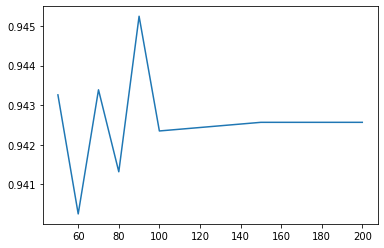

In [104]:
ns = [50, 60, 70, 80, 90, 100, 150, 200]
cv_scores = []
for n in ns:
    rf_ = RandomForestClassifier(n_estimators=n, random_state=random_state)
    cv_scores.append(calculate_cross_val_score(rf_, X[features_to_use], y))
    
plt.plot(ns, cv_scores)

In [105]:
rf_parameters = {
    'max_features': [7, 8, 9, 10, 15, 20],
    'max_depth': [None, 5, 6, 7, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
}

In [106]:
rgs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=random_state, n_jobs=-1),
                        rf_parameters, 
                        n_iter=100,
                        scoring='f1',
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state))

In [107]:
rgs_rf.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=505, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=505),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 6, 7, 8, 10, 12],
                                        'max_features': [7, 8, 9, 10, 15, 20]},
                   scoring='f1')

In [108]:
rgs_rf.best_score_, rgs_rf.best_params_

(0.9480786523013076,
 {'max_features': 9, 'max_depth': None, 'criterion': 'gini'})

20


Text(0.5, 1.0, 'RF (tuned) Feature Importance')

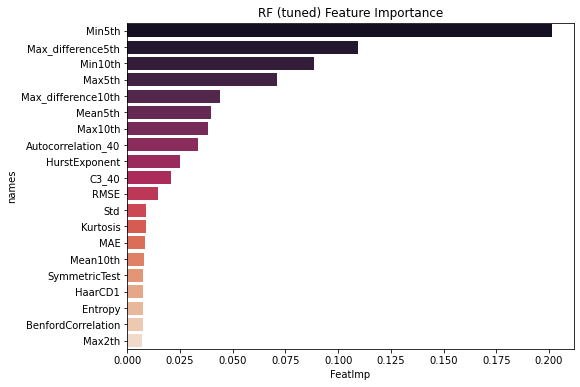

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))

feat_imp = pd.DataFrame({
    'names': X.columns,
    'FeatImp': rgs_rf.best_estimator_.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0.007]
print(feat_imp.shape[0])
rgs_rf_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('RF (tuned) Feature Importance')

In [114]:
results_features[f'RF FE ({len(rgs_rf_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in set(rgs_rf_to_use)) * 1)

In [113]:
evaluate_feature_selection_method(rgs_rf_to_use, f'RF FE ({len(rgs_rf_to_use)})')

Method: RF FE (20)
Decision Tree: 0.914
SVM: 0.897
RF: 0.941
Mean: 0.917
Save results into results_models dataframe


### 4. XGBoost FE
Feature importance определяется аналогично случайному лесу

In [116]:
gb = GradientBoostingClassifier(random_state=random_state)

In [119]:
gb.fit(X, y)

GradientBoostingClassifier(random_state=505)

8


Text(0.5, 1.0, 'XGBoost Feature Importance')

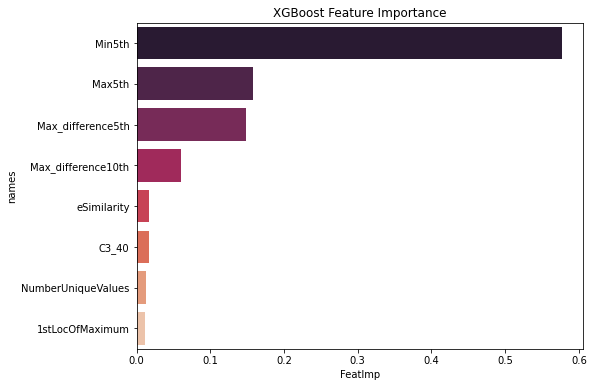

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))

feat_imp = pd.DataFrame({
    'names': X.columns,
    'FeatImp': rgs.best_estimator_.feature_importances_})
feat_imp = feat_imp.sort_values(by='FeatImp', ascending=False)
feat_imp = feat_imp.loc[feat_imp['FeatImp'] > 0]
print(feat_imp.shape[0])
gb_to_use = feat_imp['names']


sns.barplot(x=feat_imp['FeatImp'], y=feat_imp['names'], palette='rocket')
plt.title('XGBoost Feature Importance')

In [121]:
results_features[f'XGBoost ({len(gb_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in set(gb_to_use)) * 1)

In [122]:
evaluate_feature_selection_method(gb_to_use, f'XGBoost ({len(gb_to_use)})')

Method: XGBoost (8)
Decision Tree: 0.893
SVM: 0.875
RF: 0.936
Mean: 0.901
Save results into results_models dataframe


### Permutation Importance
Permutation Importance - метод, который определяет важность признаков следующим образом: измеряется на сколько ухудшается качество модели, если все значения данного признака перемешать случайным образом. Чем важнее признак, тем сильнее ухудшится качество модели. 

In [148]:
r2 = permutation_importance(fitted_tree, X, y, scoring='f1', n_repeats=5)

In [152]:
pe_to_use = set()

for i in r2.importances_mean.argsort()[::-1]:
     if r2.importances_mean[i] - 1. * r2.importances_std[i] > 0:
            pe_to_use.add(X.columns[i])
            print(f"{X.columns[i]:<30}"
              f"{r2.importances_mean[i]:.3f}"
              f" +/- {r2.importances_std[i]:.3f}")

Min5th                        0.273 +/- 0.014
Max5th                        0.110 +/- 0.007
Max_difference5th             0.080 +/- 0.004
Max_difference10th            0.078 +/- 0.005
Min10th                       0.032 +/- 0.004
C3_40                         0.030 +/- 0.003
Mean5th                       0.028 +/- 0.004
1stLocOfMaximum               0.019 +/- 0.002
Autocorrelation_40            0.017 +/- 0.004
RegularityTestKurtosisStd     0.016 +/- 0.003
NumberUniqueValues            0.013 +/- 0.003
ComplexityEstimation          0.010 +/- 0.002
RegularityTestKurtosisMean    0.009 +/- 0.001
Max_difference2th             0.007 +/- 0.002
eSimilarity                   0.007 +/- 0.001
Min2th                        0.007 +/- 0.002
Autocorrelation_8             0.006 +/- 0.002
Kurtosis                      0.004 +/- 0.001
RegularityTestSkewMedian      0.004 +/- 0.001
ModeFreq                      0.002 +/- 0.000
Sum                           0.002 +/- 0.001
RunsTest                      0.00

In [154]:
results_features[f'Perm Imp ({len(pe_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in pe_to_use) * 1)

In [155]:
evaluate_feature_selection_method(pe_to_use, f'Perm Imp ({len(pe_to_use)})')

Method: Perm Imp (27)
Decision Tree: 0.92
SVM: 0.889
RF: 0.945
Mean: 0.918
Save results into results_models dataframe


### RFE
Recursive Feature Elimination использует подход рекурсивного уменьшения количества признаков до тех пор, пока не будет достигнуто необходимое количество.

In [213]:
rfe = RFE(estimator=DecisionTreeClassifier(max_depth=5, random_state=random_state), n_features_to_select=10)
rfe.fit(X[features_to_use], y)

RFE(estimator=DecisionTreeClassifier(max_depth=5, random_state=505),
    n_features_to_select=10)

In [214]:
rfe_to_use = np.array(features_to_use)[rfe.support_]

In [215]:
rfe_to_use

array(['Min5th', 'eSimilarity', 'Max_difference5th', 'BenfordCorrelation',
       'Max5th', 'MaxAutocorrCoeffs', 'Max10th', 'Min10th', 'Unique2th',
       'NumberUniqueValues'], dtype='<U28')

In [217]:
results_features[f'RFE ({len(rfe_to_use)})'] = \
    results_features['feature_name'].apply(lambda feat: (feat in set(rfe_to_use)) * 1)

In [216]:
evaluate_feature_selection_method(rfe_to_use, f'RFE ({len(rfe_to_use)})')

Method: RFE (10)
Decision Tree: 0.914
SVM: 0.886
RF: 0.944
Mean: 0.915
Save results into results_models dataframe


# Результаты
Результаты сохранены в 2 датафрейма
- `results_features` - строки: признаки, столбцы: методы отбора признаков, на пересечении: 0/1 в зависимости от того, используется ли этот признак при таком методе отбора
- `results_models` - строки: методы отбора признаков, столбцы: 3 выбранные модели, на пересечении: значения f1-меры на кросс-валидации

In [265]:
results_features.head()

,feature_name,Baseline (76),Correlation (64),Anova (35),Kendall (20),Linear weights (34),DT FE (8),RF FE (13),RF FE (20),XGBoost (8),Chi2 (40),Perm Imp (27),RFE (10)
0,Mean,1,1,1,1,0,0,0,0,0,1,0,0
1,Std,1,1,1,1,1,0,1,1,0,1,0,0
2,Median,1,1,0,0,0,0,0,0,0,0,0,0
3,Skew,1,1,0,0,0,0,0,0,0,0,0,0
4,Kurtosis,1,1,1,1,1,0,1,1,0,1,1,0


In [264]:
results_models.head()

,DecisionTree,SVM,RF,Mean
Baseline (76),0.908,0.874,0.944,0.909
Correlation (64),0.913,0.878,0.942,0.911
Anova (35),0.911,0.891,0.943,0.915
Kendall (20),0.904,0.882,0.931,0.906
Chi2 (40),0.910,0.888,0.943,0.914


Подсчитана частота, с которой каждый признак выбирался методами отбора

In [227]:
results_features_index = results_features.set_index(['feature_name'])
results_features_index.loc[:, 'Mean'] = np.mean(results_features_index, axis=1)

In [231]:
results_features = results_features_index.reset_index()

In [266]:
results_features.head()

,feature_name,Baseline (76),Correlation (64),Anova (35),Kendall (20),Linear weights (34),DT FE (8),RF FE (13),RF FE (20),XGBoost (8),Chi2 (40),Perm Imp (27),RFE (10),Mean
0,Mean,1,1,1,1,0,0,0,0,0,1,0,0,0.416667
1,Std,1,1,1,1,1,0,1,1,0,1,0,0,0.666667
2,Median,1,1,0,0,0,0,0,0,0,0,0,0,0.166667
3,Skew,1,1,0,0,0,0,0,0,0,0,0,0,0.166667
4,Kurtosis,1,1,1,1,1,0,1,1,0,1,1,0,0.750000


Отобраны те признаки, которые использовались более чем половиной методов отбора

In [247]:
top_features = results_features.sort_values(by=['Mean'], ascending=False) \
                    .loc[results_features['Mean'] > 0.5, ['feature_name', 'Mean']] \
                    .reset_index(drop=True)

top_features

,feature_name,Mean
0,Min5th,1.000000
1,C3_40,0.916667
2,Max_difference5th,0.916667
3,Min10th,0.833333
4,Max5th,0.833333
5,eSimilarity,0.750000
6,Kurtosis,0.750000
7,Mean5th,0.750000
8,Max10th,0.750000
9,Autocorrelation_40,0.750000


In [250]:
top_features_list = top_features['feature_name'].tolist()

Проверено качество, которое получается при использовании полученного набора признаков

In [257]:
evaluate_feature_selection_method(top_features_list, f'Top features ({len(top_features_list)})')

Method: Top features (16)
Decision Tree: 0.909
SVM: 0.903
RF: 0.944
Mean: 0.919
Save results into results_models dataframe


Таблица с качеством классификации после применения каждого метода отсортирована по убыванию среднего качества

In [258]:
results_models.sort_values(by='Mean', ascending=False)

,DecisionTree,SVM,RF,Mean
Top features (16),0.909,0.903,0.944,0.919
Perm Imp (27),0.920,0.889,0.945,0.918
RF FE (20),0.914,0.897,0.941,0.917
Anova (35),0.911,0.891,0.943,0.915
RFE (10),0.914,0.886,0.944,0.915
Chi2 (40),0.910,0.888,0.943,0.914
RF FE (13),0.907,0.896,0.939,0.914
Correlation (64),0.913,0.878,0.942,0.911
Baseline (76),0.908,0.874,0.944,0.909
Kendall (20),0.904,0.882,0.931,0.906


Таким образом, удалось повысить среднее качество классификации трёх алгоритмов, используя 16 отобранных признаков вместо начальных 76. Полученный список признаков:

In [270]:
print(top_features_list)

['Min5th', 'C3_40', 'Max_difference5th', 'Min10th', 'Max5th', 'eSimilarity', 'Kurtosis', 'Mean5th', 'Max10th', 'Autocorrelation_40', 'NumberUniqueValues', 'Std', 'HurstExponent', 'Mean10th', 'Entropy', 'BenfordCorrelation']
